<h1>Advanced Regression</h1>

<h2>Importing libraries</h2>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor

<h2>Reading data</h2>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hour.csv to hour.csv


In [ ]:
df = pd.read_csv('hour.csv', parse_dates=['dteday'])

Drop index.

In [ ]:
df = df.drop(['instant'], axis=1)

In [ ]:
df

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


<h2>EDA and data preprocessing</h2>

We have no missing data.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   yr          17379 non-null  int64         
 3   mnth        17379 non-null  int64         
 4   hr          17379 non-null  int64         
 5   holiday     17379 non-null  int64         
 6   weekday     17379 non-null  int64         
 7   workingday  17379 non-null  int64         
 8   weathersit  17379 non-null  int64         
 9   temp        17379 non-null  float64       
 10  atemp       17379 non-null  float64       
 11  hum         17379 non-null  float64       
 12  windspeed   17379 non-null  float64       
 13  casual      17379 non-null  int64         
 14  registered  17379 non-null  int64         
 15  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), 

Let's demote numeric and categorical data.

In [ ]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
categorical_features  =['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']

In [ ]:
def plot_box_and_hist(df, column):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 5))
    sns.boxplot(x=df[column], ax=ax_box)
    sns.histplot(x=df[column], ax=ax_hist, kde=True)
    plt.suptitle(f'Boxplot and Hist for {column}', fontsize=14)
    f.subplots_adjust(top=0.9)
    plt.show()

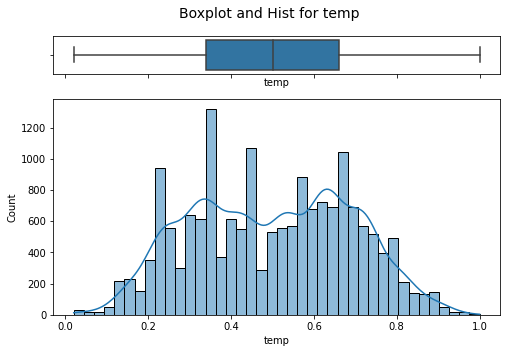

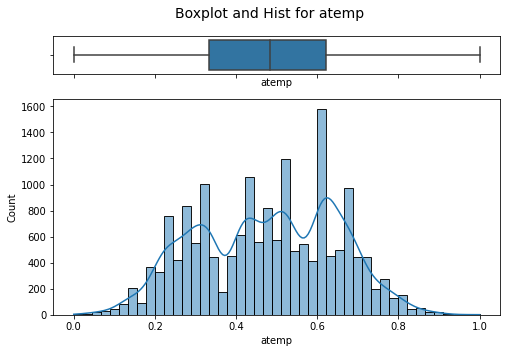

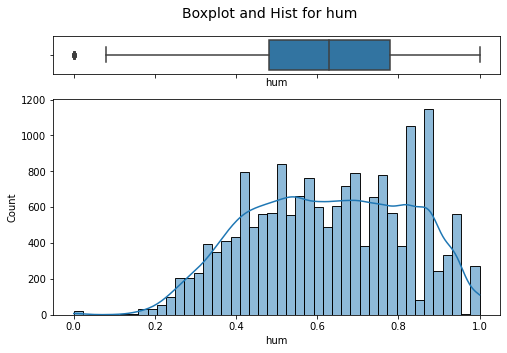

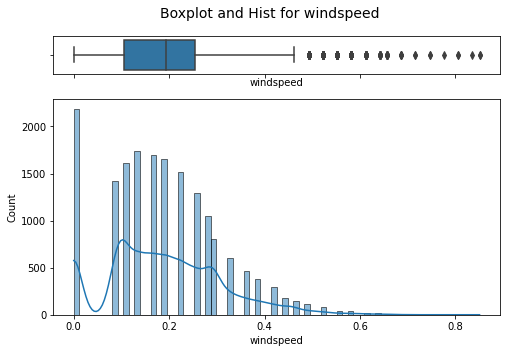

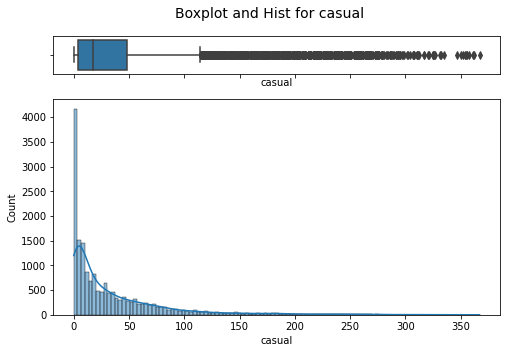

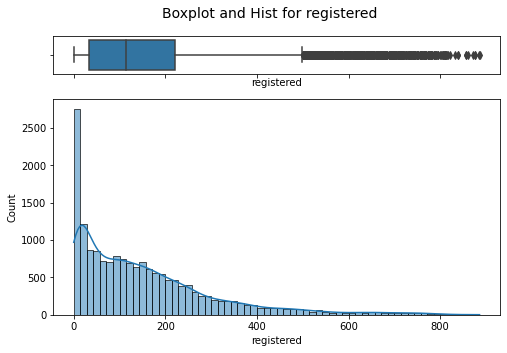

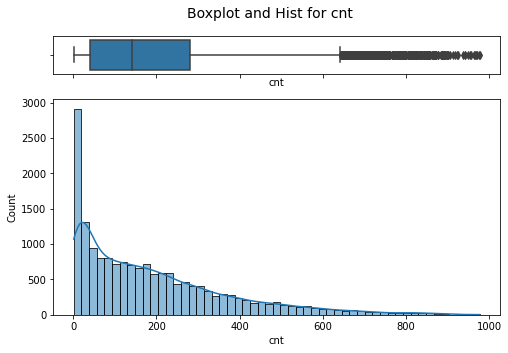

In [ ]:
for feature in df[numeric_features].columns:
    plot_box_and_hist(df, feature)

Target values are not normally distributed (distribution seems to be exponential-like). Also all the numeric data is already scaled between 0 and 1.

Here we can see that categorical data for <b>'season'</b>, <b>'yr'</b>, <b>'mnth'</b>, <b>'hr'</b> and <b>'weekday'</b> variables is uniformly distributed. There are very few holidays (not surprising).

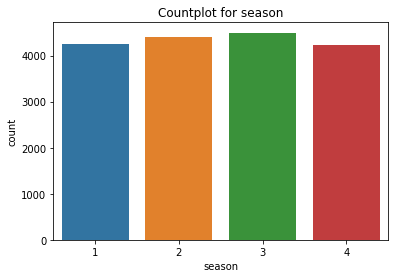

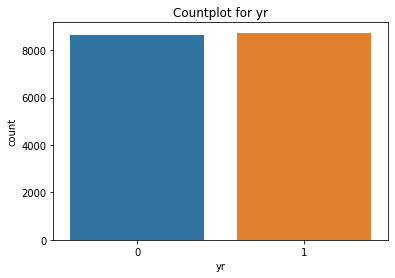

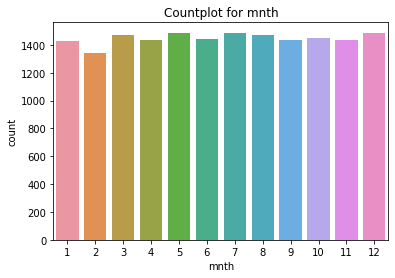

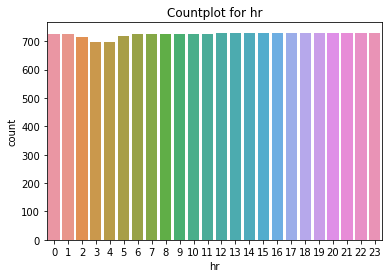

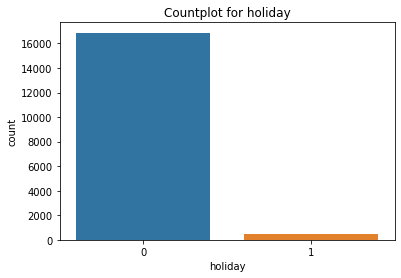

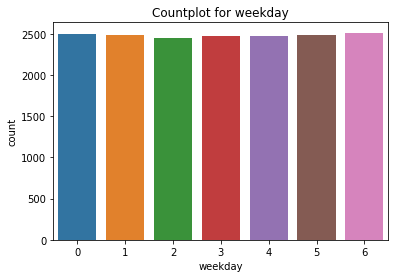

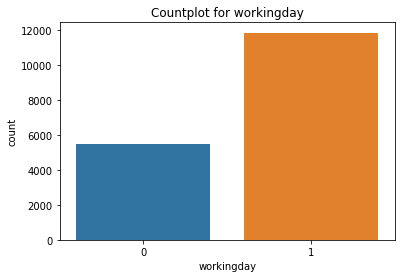

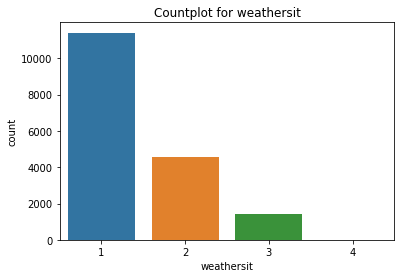

In [ ]:
for feature in categorical_features:
    sns.countplot(x=feature, data=df)
    plt.title(f'Countplot for {feature}')
    plt.show() 

A we can see, there are only 3 objects with <b>'weathersit'</b> variable equal to 4 (Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog).

In [ ]:
df['weathersit'].value_counts()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

Let's look at the correlation matrix. <b>temp</b> and <b>'atemp'</b> variables are correlated highly.

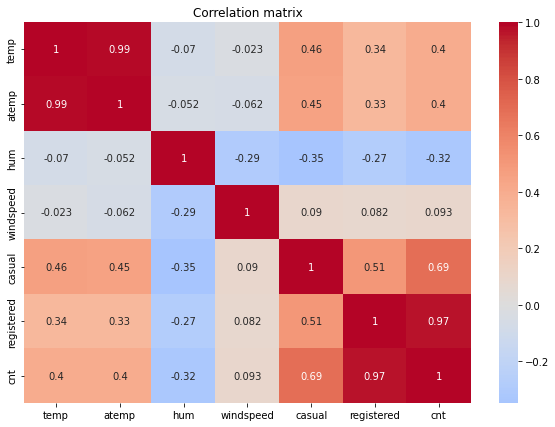

In [ ]:
corrmat = df[numeric_features].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(data=corrmat, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation matrix')
plt.show()

In [ ]:
numeric_features = numeric_features[:4]

Let's look at dependencies. At first sight, all the numeric data and target are independent (and that's one of the reasons why linear regression probably won't be useful). But some inference might be derived: there are less high numbers of rental bikes for low temperature and low feeling temperature (<b>'temp'</b> and <b>'atemp'</b> variables); for low humidity (<b>'hum'</b> variable) there are low number of rental bikes and for high humidity this number is not large; the number of rental bikes is low for high windspeed.

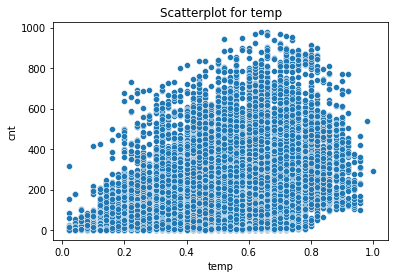

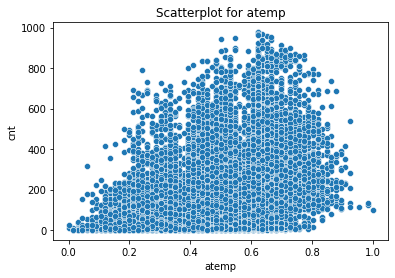

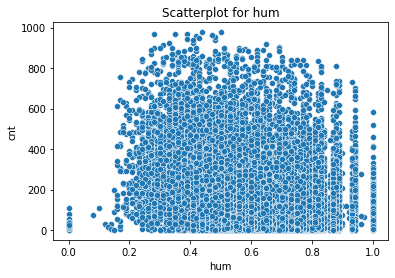

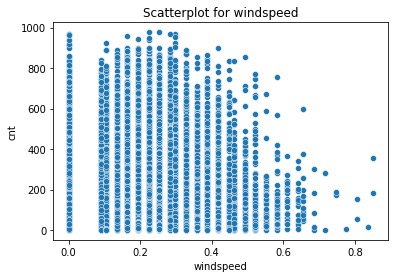

In [ ]:
for feature in numeric_features:
    sns.scatterplot(x=feature, y='cnt', data=df)
    plt.title(f'Scatterplot for {feature}')
    plt.show()

It's time to transform our categorical data. Let's apply OneHotEncoder to it.

In [ ]:
ohe = OneHotEncoder(sparse=False)
temp = pd.DataFrame(data=ohe.fit_transform(df[categorical_features]), columns=ohe.get_feature_names(categorical_features))
df_onehot = df.drop(categorical_features, axis=1).merge(temp, left_index=True, right_index=True)
df_onehot

,dteday,temp,atemp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,yr_0,yr_1,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,holiday_0,holiday_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,2011-01-01,0.24,0.2879,0.81,0.0000,3,13,16,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2011-01-01,0.22,0.2727,0.80,0.0000,8,32,40,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2011-01-01,0.22,0.2727,0.80,0.0000,5,27,32,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2011-01-01,0.24,0.2879,0.75,0.0000,3,10,13,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2011-01-01,0.24,0.2879,0.75,0.0000,0,1,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,0.26,0.2576,0.60,0.1642,11,108,119,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
17375,2012-12-31,0.26,0.2576,0.60,0.1642,8,81,89,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
17376,2012-12-31,0.26,0.2576,0.60,0.1642,7,83,90,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
17377,2012-12-31,0.26,0.2727,0.56,0.1343,13,48,61,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


Let's make a split. Since our data is ordered by time, we shouldn't shuffle our data (we'd get data leakage otherwise). But conditions of the task tell us that we should sample data randomly unless explicitly stated otherwise. So let's do it.

In [ ]:
df_train, df_test = train_test_split(df_onehot, test_size=0.3, random_state=42)
df_test.reset_index(drop=True, inplace=True)

Some features are binary (<b>'yr'</b>, <b>'holiday'</b>, <b>'workingday'</b>), so we don't need two columns for them (after encoding). Also <b>'atemp'</b> is correlated with <b>'temp'</b> very highly (0.99), so let's drop it. Also we probably don't need <b>'season'</b> variable, since we have months (<b>'season'</b> contains the same type of information but with less precision). Let's drop it for experiment.

In [ ]:
X_train = df_train.drop(['dteday', 'atemp', 'season_1', 'season_2', 'season_3', 'season_4', 'casual', 'registered', 'cnt', 'yr_0', 'holiday_0', 'workingday_0'], axis=1)
y_train = df_train['cnt']
X_test = df_test.drop(['dteday', 'atemp', 'season_1', 'season_2', 'season_3', 'season_4', 'casual', 'registered', 'cnt', 'yr_0', 'holiday_0', 'workingday_0'], axis=1)
y_test = df_test['cnt']

Let's also apply <b>'sqrt'</b> transformation for features (it gives us slightly better metrics).

In [ ]:
X_train = X_train.apply(np.sqrt)
X_test = X_test.apply(np.sqrt)

<h2>Evaluating models</h2>

We shold use MAE metric. Also we'll use R2, since it is easy to interpret.

In [ ]:
def evaluate_model(est, X_train, X_test, y_train, y_test):
    est.fit(X_train, y_train)
    y_tr_pred = est.predict(X_train)
    y_test_pred = est.predict(X_test)
    r2_train = r2_score(y_train, y_tr_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'R2 Train Score: {r2_train}')
    print(f'R2 Test Score: {r2_test}')
    print(f'R2 adjusted Train Score: {1 - ((1 - r2_train) * ((len(X_train) - 1) / (len(X_train) - len(X_train.columns) - 1)))}')
    print(f'R2 adjusted Test Score: {1 - ((1 - r2_test) * ((len(X_test) - 1) / (len(X_test) - len(X_test.columns) - 1)))}')
    print(f'MAE Train: {mean_absolute_error(y_train, y_tr_pred)}')
    print(f'MAE Test: {mean_absolute_error(y_test, y_test_pred)}')

<h3>KNearNeighbors</h3>

In [ ]:
params = {'n_neighbors': [1, 3, 5, 7, 10, 15, 20]}
print('KNN Regressor')
print()
knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params,
                         scoring='neg_mean_absolute_error', n_jobs=-1)
evaluate_model(knn, X_train, X_test, y_train, y_test)

KNN Regressor

R2 Train Score: 0.9999873070643043
R2 Test Score: 0.716178689794836
R2 adjusted Train Score: 0.9999872515176449
R2 adjusted Test Score: 0.7132634709109458
MAE Train: 0.010933004521167283
MAE Test: 56.186037591100884


In [ ]:
knn.best_params_

{'n_neighbors': 1}

<h3>Decision tree</h3>

Results are significantly better than KNN.

In [ ]:
params = {'max_depth': [5, 10, 15, 20, 25, 50, 100, 150], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 5, 10, 15]}
print('Decision Tree Regressor')
print()
tree = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=params,
                         scoring='neg_mean_absolute_error', n_jobs=-1)
evaluate_model(tree, X_train, X_test, y_train, y_test)

Decision Tree Regressor

R2 Train Score: 0.9523276972287861
R2 Test Score: 0.8708835036688247
R2 adjusted Train Score: 0.9521190743201184
R2 adjusted Test Score: 0.8695573070979813
MAE Train: 24.131691467412796
MAE Test: 38.91700780998825


In [ ]:
tree.best_params_

{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 15}

<h3>RandomForest</h3>

We'll use best parameters from DecisionTreeRegressor and use <b>'n_estimators'</b> parameters only for GridSearch (otherwise it would take very much time).

In [ ]:
params = {'n_estimators': [80, 100, 150, 200]}
print('Random Forest Regressor')
print()
forest = GridSearchCV(estimator=RandomForestRegressor(max_depth=50, n_jobs=-1, random_state=42), param_grid=params,
                         scoring='neg_mean_absolute_error', n_jobs=-1)
evaluate_model(forest, X_train, X_test, y_train, y_test)

Random Forest Regressor

R2 Train Score: 0.9885040619597032
R2 Test Score: 0.9218223517699438
R2 adjusted Train Score: 0.988453753585817
R2 adjusted Test Score: 0.9210193642978133
MAE Train: 12.071306237645079
MAE Test: 31.095970283759844


In [ ]:
forest.best_params_

{'n_estimators': 200}

<h3>SVM Regression</h3>

Even better than random foreest (C = 500 and epsilon = 0.1 are best found parameters)

In [ ]:
print('SVM Regressor')
print()
svr = SVR(C=500, epsilon=0.1)
evaluate_model(svr, X_train, X_test, y_train, y_test)

SVM Regressor

R2 Train Score: 0.9522009977319436
R2 Test Score: 0.9285085218365531
R2 adjusted Train Score: 0.9519918203625928
R2 adjusted Test Score: 0.9277742101422386
MAE Train: 18.89980381739398
MAE Test: 29.36821941438145


<h3>Gradient Boosting Regression</h3>

We'll use LightGBM algorithm for our task. Judging by results, we may conclude this is the best model so far.

In [ ]:
params = {'n_estimators': [80, 100, 150, 200], 'max_depth': [10, 20, 30, 40], 'num_leaves': [20, 31, 50, 90, 100, 120]}
print('LGBM Regressor')
print()
lgb = GridSearchCV(estimator=LGBMRegressor(random_state=42), param_grid=params,
                         scoring='neg_mean_absolute_error', n_jobs=-1)
evaluate_model(lgb, X_train, X_test, y_train, y_test)

LGBM Regressor

R2 Train Score: 0.9764773588359327
R2 Test Score: 0.9403291966405738
R2 adjusted Train Score: 0.976374419360935
R2 adjusted Test Score: 0.9397162988541301
MAE Train: 18.736280115027082
MAE Test: 28.09571871463751


In [ ]:
lgb.best_params_

{'max_depth': 30, 'n_estimators': 200, 'num_leaves': 90}

<h2>Training on 2011 year</h2>

Let's train our model on one year and validate it on another.

In [ ]:
df_train = df_onehot[df_onehot['yr_1'] == 0]
df_test = df_onehot[df_onehot['yr_1'] == 1]
df_test.reset_index(drop=True, inplace=True)

In [ ]:
X_train = df_train.drop(['dteday', 'casual', 'registered', 'cnt', 'yr_0', 'yr_1', 'holiday_0', 'workingday_0'], axis=1)
y_train = df_train['cnt']
X_test = df_test.drop(['dteday', 'casual', 'registered', 'cnt', 'yr_0', 'yr_1', 'holiday_0', 'workingday_0'], axis=1)
y_test = df_test['cnt']

In [ ]:
X_train = X_train.apply(np.sqrt)
X_test = X_test.apply(np.sqrt)

The result is significantly worse. Not surprising: our previous results were so high due to data leakage.

In [ ]:
params = {'n_estimators': [80, 100, 150, 200], 'max_depth': [10, 20, 30, 40], 'num_leaves': [10, 20, 31, 50, 90, 100]}
print('LGBM Regressor')
print()
lgb = GridSearchCV(estimator=LGBMRegressor(random_state=42), param_grid=params,
                         scoring='neg_mean_absolute_error', n_jobs=-1, cv=TimeSeriesSplit())
evaluate_model(lgb, X_train, X_test, y_train, y_test)

LGBM Regressor

R2 Train Score: 0.9476358547796392
R2 Test Score: 0.6324732913819082
R2 adjusted Train Score: 0.947288264669291
R2 adjusted Test Score: 0.630058696823214
MAE Train: 20.540018649413415
MAE Test: 90.95674906350838


In [ ]:
lgb.best_params_

{'max_depth': 20, 'n_estimators': 200, 'num_leaves': 20}

Since the results are not so high, let's perform residual analysis to find possible reason. Judging by histogram and scatterplot below, we can say that our model makes systematic error (predicts generally lower values than it should). We tried to transform feature and target with PowerTransformer and QuantileTransformer but results were quite the same.

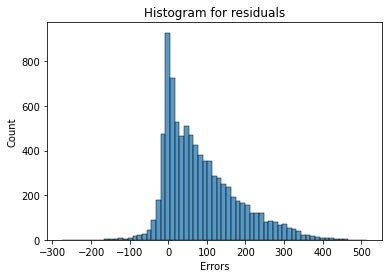

In [ ]:
errors = y_test - lgb.best_estimator_.predict(X_test)
sns.histplot(x=errors)
plt.xlabel('Errors')
plt.title('Histogram for residuals')
plt.show()

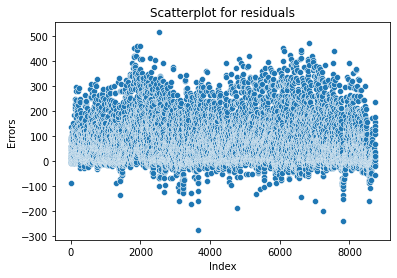

In [ ]:
sns.scatterplot(x=range(len(errors)), y=errors)
plt.xlabel('Index')
plt.ylabel('Errors')
plt.title('Scatterplot for residuals')
plt.show()

<h2>Predicting two targets</h2>

In [ ]:
X_train = df_train.drop(['dteday', 'casual', 'registered', 'cnt', 'yr_0', 'yr_1', 'holiday_0', 'workingday_0'], axis=1)
y_train1 = df_train['casual']
y_train2 = df_train['registered']
X_test = df_test.drop(['dteday', 'casual', 'registered', 'cnt', 'yr_0', 'yr_1', 'holiday_0', 'workingday_0'], axis=1)
y_test1 = df_test['casual']
y_test2 = df_test['registered']

In [ ]:
X_train = X_train.apply(np.sqrt)
X_test = X_test.apply(np.sqrt)

Our model performed quite well on <b>'casual'</b> variable.



In [ ]:
params = {'n_estimators': [80, 100, 150, 200], 'max_depth': [10, 20, 30, 40], 'num_leaves': [10, 20, 31, 50, 90, 100]}
print('LGBM Regressor')
print()
lgb1 = GridSearchCV(estimator=LGBMRegressor(random_state=42), param_grid=params,
                         scoring='neg_mean_absolute_error', n_jobs=-1, cv=TimeSeriesSplit())
evaluate_model(lgb1, X_train, X_test, y_train1, y_test1)

LGBM Regressor

R2 Train Score: 0.8855183462472251
R2 Test Score: 0.717798220445822
R2 adjusted Train Score: 0.8847584237755927
R2 adjusted Test Score: 0.7159441976894149
MAE Train: 8.275078612290434
MAE Test: 17.222967333044398


But not very well on <b>'registered'</b> variable.

In [ ]:
params = {'n_estimators': [80, 100, 150, 200], 'max_depth': [10, 20, 30, 40], 'num_leaves': [10, 20, 31, 50, 90, 100]}
print('LGBM Regressor')
print()
lgb2 = GridSearchCV(estimator=LGBMRegressor(random_state=42), param_grid=params,
                         scoring='neg_mean_absolute_error', n_jobs=-1, cv=TimeSeriesSplit())
evaluate_model(lgb2, X_train, X_test, y_train2, y_test2)

LGBM Regressor

R2 Train Score: 0.946823002700622
R2 Test Score: 0.6116177638558498
R2 adjusted Train Score: 0.9464700169260716
R2 adjusted Test Score: 0.6090661516543494
MAE Train: 16.813765764184094
MAE Test: 77.72579748881317


In [ ]:
lgb1.best_params_

{'max_depth': 10, 'n_estimators': 200, 'num_leaves': 10}

In [ ]:
lgb2.best_params_

{'max_depth': 20, 'n_estimators': 200, 'num_leaves': 20}

Results on our initial target (<b>'cnt'</b>) are slightly worse (almost the same). To explain why, let's perform residual analysis.

In [ ]:
y_pred = lgb1.best_estimator_.predict(X_test) + lgb2.best_estimator_.predict(X_test)
print('Test MAE:', mean_absolute_error(y_test, y_pred))
print('Test R2:', r2_score(y_test, y_pred))

Test MAE: 91.2623540907152
Test R2: 0.627489328429705


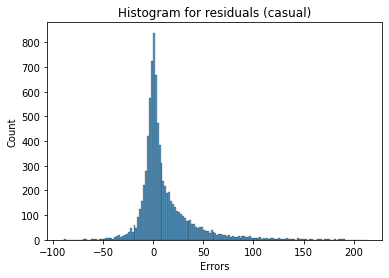

In [ ]:
errors = y_test1 - lgb1.best_estimator_.predict(X_test)
sns.histplot(x=errors)
plt.xlabel('Errors')
plt.title('Histogram for residuals (casual)')
plt.show()

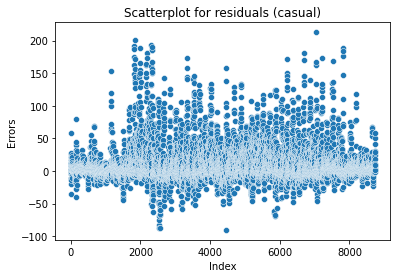

In [ ]:
sns.scatterplot(x=range(len(errors)), y=errors)
plt.xlabel('Index')
plt.ylabel('Errors')
plt.title('Scatterplot for residuals (casual)')
plt.show()

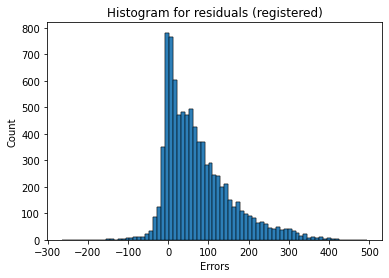

In [ ]:
errors = y_test2 - lgb2.best_estimator_.predict(X_test)
sns.histplot(x=errors)
sns.histplot(x=errors)
plt.xlabel('Errors')
plt.title('Histogram for residuals (registered)')
plt.show()

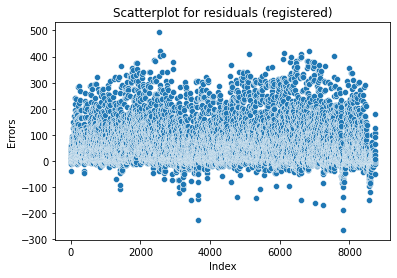

In [ ]:
sns.scatterplot(x=range(len(errors)), y=errors)
plt.xlabel('Index')
plt.ylabel('Errors')
plt.title('Scatterplot for residuals (registered)')
plt.show()

As we have seen, for <b>'registered'</b> variable we have the same systematic error (values are generally lower than they should be). As for <b>'casual'</b> variable, this error is weaker but it still exixts (histogram's right tail is slightly thicker than left one). Those two predictions were summed (while they are biased the same way) and thus they gave us a slightly bigger error. 

<h2>Feature importances</h2>

Let's check a hypothesis: the results were poor because we didn't have enough train data. Also data for 2011 and 2012 are not very similar (maybe because of business problems or business success of this bike rental company). We should train our model on more train data and we shouldn't shuffle it (otherwise we'll get data leakage). Also we should add <b>'yr'</b> varible (for two previous models it was quite useless). Also during cross-validation we should use TimeSeriesSplit (as we did two previous times). We'll use all the features to perform feature importance analysis afterwards.

In [ ]:
df_train, df_test = train_test_split(df_onehot, test_size=0.3, shuffle=False)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
X_train = df_train.drop(['dteday', 'casual', 'registered', 'cnt', 'yr_0', 'holiday_0', 'workingday_0'], axis=1)
y_train = df_train['cnt']
X_test = df_test.drop(['dteday', 'casual', 'registered', 'cnt', 'yr_0', 'holiday_0', 'workingday_0'], axis=1)
y_test = df_test['cnt']

In [ ]:
X_train = X_train.apply(np.sqrt)
X_test = X_test.apply(np.sqrt)

In [ ]:
params = {'n_estimators': [80, 100, 150, 200], 'max_depth': [10, 20, 30, 40], 'num_leaves': [10, 20, 31, 50, 90, 100]}
print('LGBM Regressor')
print()
lgb = GridSearchCV(estimator=LGBMRegressor(random_state=42), param_grid=params,
                         scoring='neg_mean_absolute_error', n_jobs=-1, cv=TimeSeriesSplit())
evaluate_model(lgb, X_train, X_test, y_train, y_test)

LGBM Regressor

R2 Train Score: 0.944603410490649
R2 Test Score: 0.8715141167159556
R2 adjusted Train Score: 0.9443380047256116
R2 adjusted Test Score: 0.8700684947507811
MAE Train: 24.271161871073048
MAE Test: 57.72253916327513


In [ ]:
lgb.best_params_

{'max_depth': 20, 'n_estimators': 200, 'num_leaves': 20}

The results are much better. Systematic error has been disappeared.

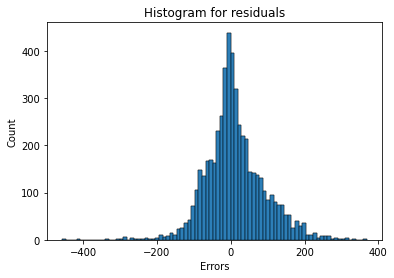

In [ ]:
errors = y_test - lgb.best_estimator_.predict(X_test)
sns.histplot(x=errors)
sns.histplot(x=errors)
plt.xlabel('Errors')
plt.title('Histogram for residuals')
plt.show()

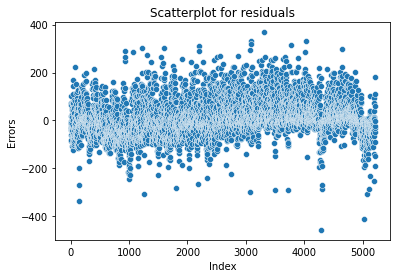

In [ ]:
sns.scatterplot(x=range(len(errors)), y=errors)
plt.xlabel('Index')
plt.ylabel('Errors')
plt.title('Scatterplot for residuals')
plt.show()

Let's estimate feature importances. We'll use feature_importance_ attribute of LGBMRegressor (the more is value the larger is number of splits by this variable).

In [ ]:
importances = pd.DataFrame({'feature': X_train.columns, 'importance': lgb.best_estimator_.feature_importances_})
importances = importances.sort_values(by='importance', ascending=False)

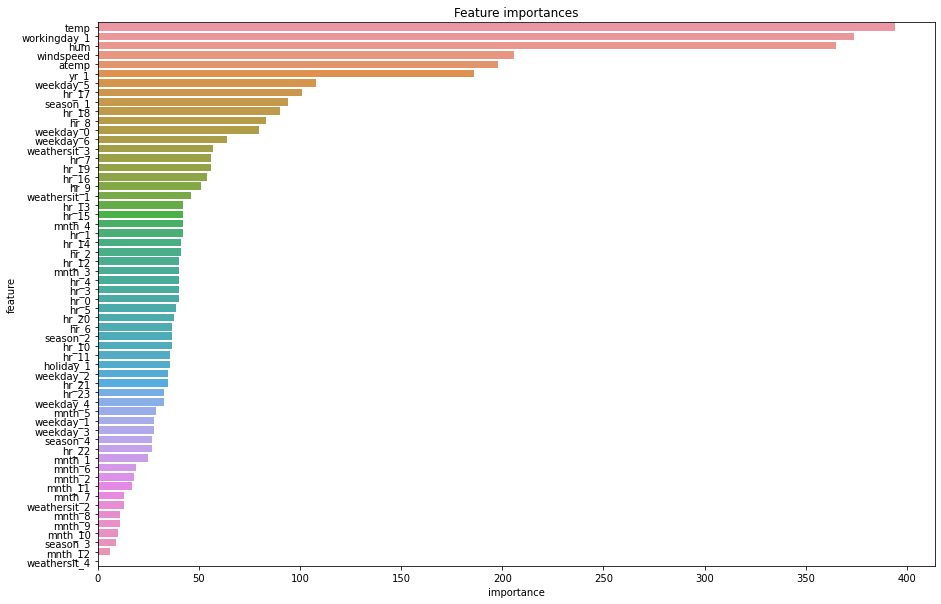

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(x='importance', y='feature', data=importances)
plt.title('Feature importances')
plt.show()

<h2>Conclusion</h2>

A we can see, <b>'temp'</b> variable is more important than <b>'atemp'</b>. Judging by the barplot above, we also may conclude that <b>'hour'</b> is slightly more important than <b>'season'</b>. The most important features are temperature, is day is working day, humidity, windspeed, feeling temperature and year. There are less high numbers of rental bikes for low temperature and low feeling temperature (<b>'temp'</b> and <b>'atemp'</b> variables); for low humidity (<b>'hum'</b> variable) there are low number of rental bikes and for high humidity this number is not large; the number of rental bikes is low for high windspeed (this can be derived from the scatterplots above).